In [107]:
%matplotlib inline
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

print("TF version: ", tf.__version__)
print("Keras version: ", keras.__version__)

TF version:  2.6.0
Keras version:  2.6.0


In [108]:
def plot_img(img: np.array, label: int, sqz: bool = True):
    print('Number:', label)
    if sqz:
        img = img.squeeze()
    plt.imshow(img, cmap='Greys_r')

In [125]:
# Getting the mnist dataset
mnist = keras.datasets.mnist
(X_train, y_train), (X_dev, y_dev) = mnist.load_data()


# Normalize to values between 0 and 1
rescale = layers.Rescaling(1./255)


# Rescaling and reshaping the dataset
X_train = tf.reshape(rescale(X_train), shape=(-1, 28, 28, 1))
X_dev = tf.reshape(rescale(X_dev), shape=(-1, 28, 28, 1))

# First Padding
padding = [[0, 0], [1, 1], [1, 1], [0, 0]]
X_train = tf.pad(X_train, padding)
X_dev = tf.pad(X_dev, padding)

# Sequence of transformations for data augmentation
transform = keras.Sequential([
    layers.RandomRotation(0.01),
    layers.RandomTranslation(0.18, 0.18),
    layers.RandomZoom((-0.1, 0.05)),
])


# Apply the transformations and the second padding to the dataset
X_train = tf.pad(transform(X_train), padding)
X_dev = tf.pad(transform(X_dev), padding)

X_train.shape, X_dev.shape

(TensorShape([60000, 32, 32, 1]), TensorShape([10000, 32, 32, 1]))

Number: 9


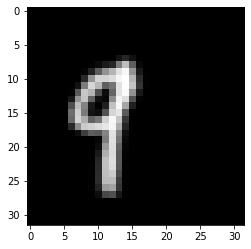

In [132]:
n = np.random.randint(X_train.shape[0])
plot_img(X_train[n].numpy(), y_train[n])

In [156]:
INPUT_SIZE = 32

# Creating the my mnist classification model
model = keras.Sequential([
    
    # First block of convolutional layers
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(INPUT_SIZE, INPUT_SIZE, 1)),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu'),
    layers.MaxPool2D(2, 2),

    # Second block of Convolutional layers
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(2, 2, padding='same'),

    # Third block of Convolutional layers 
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D(2, 1, padding='valid'),
    layers.MaxPool2D(2, 1, padding='valid'),

    layers.Dropout(rate=0.3),

    layers.Flatten(),

    # Fully connected (Dense) neural networks
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=10, activation='softmax')
], name='Mnet_V2')


# Defining some of the hyperparameters of the model
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Printing the summary of the model
model.summary()
print('\n')

Model: "Mnet_V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 32, 32, 16)        416       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 32, 32, 16)        6416      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 8, 8, 32)          0   

In [ ]:
# Callback to reduct the learning rate when it is no more effective 
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1, min_delta=1e5)


# Fitting (training) the model to the dataset
hist = model.fit(X_train, y_train,
    batch_size=32, epochs=30,
    validation_data=(X_dev, y_dev),
    callbacks=[learning_rate_reduction]
)

Epoch 1/30
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3229 - accuracy: 0.8941 - val_loss: 0.1074 - val_accuracy: 0.9691
Epoch 2/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0823 - accuracy: 0.9775 - val_loss: 0.0716 - val_accuracy: 0.9800
Epoch 3/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0663 - accuracy: 0.9816 - val_loss: 0.0598 - val_accuracy: 0.9824
Epoch 4/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0570 - accuracy: 0.9837 - val_loss: 0.0334 - val_accuracy: 0.9908

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0293 - accuracy: 0.9919 - val_loss: 0.0223 - val_accuracy: 0.9934
Epoch 6/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0249 - accuracy: 0.9927 - val_loss: 0.0295 - val_accuracy: 0.9925
Epoch 7/30
1875/1875 [=====================

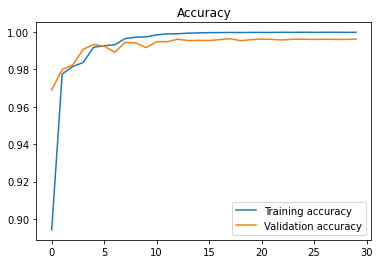

In [158]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['accuracy'])
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

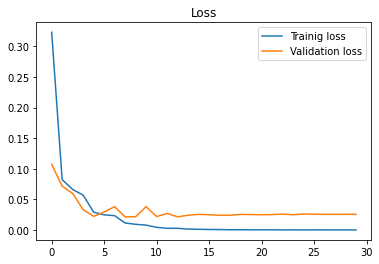

In [159]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

In [160]:
p_dev = np.argmax(model.predict(X_dev), axis=1)
p_train = np.argmax(model.predict(X_train), axis=1)

In [161]:
print("DEV F1 SCORE: ", f1_score(y_dev, p_dev, average='weighted'))
print("TRAIN F1 SCORE: ", f1_score(y_train, p_train, average='weighted'))

DEV F1 SCORE:  0.9962983882986312
TRAIN F1 SCORE:  0.9999666651786304


DEV CONFUSION MATRIX:


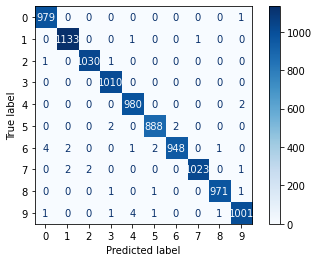

In [162]:
print("DEV CONFUSION MATRIX:")
cm = confusion_matrix(y_dev, p_dev)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(0, 10))
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation='horizontal', values_format='');

In [167]:
one = tf.constant([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16326458752155304, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0.5714263319969177, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285658299922943, 1, 1, 0.4897943437099457, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.24489717185497284, 1, 1, 1, 0, 1, 1, 0.14286039769649506, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.9996798634529114, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20408114790916443, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4285736083984375, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.9983993172645569, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.5918376445770264, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.28571316599845886, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9990395307540894, 0.7543814182281494, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], shape=(1, 28, 28, 1))

In [168]:
one = np.pad(one, padding)
one = np.pad(one, padding)
one.shape

(1, 32, 32, 1)

Number: 1


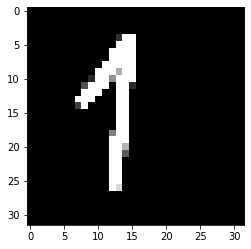

In [170]:
plot_img(one[0].squeeze(), 1)

In [171]:
p = model.predict(one)
print(p.max())
np.argmax(p)

0.99988055


1

In [172]:
model.save('DigitRecognitionModel_v5.h5')